<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Visualization" data-toc-modified-id="Visualization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Visualization</a></span><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preparation</a></span></li><li><span><a href="#Show-Image-and-Predict-LaTeX" data-toc-modified-id="Show-Image-and-Predict-LaTeX-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Show Image and Predict LaTeX</a></span></li><li><span><a href="#Show-Attention-Slices-over-Image-correspond-to-LaTeX-Symbols" data-toc-modified-id="Show-Attention-Slices-over-Image-correspond-to-LaTeX-Symbols-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Show Attention Slices over Image correspond to LaTeX Symbols</a></span></li><li><span><a href="#Save-Attention-Slices-as-GIF" data-toc-modified-id="Save-Attention-Slices-as-GIF-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Save Attention Slices as GIF</a></span></li></ul></li></ul></div>

# Visualization

## Preparation

prepare libs and load prebuild model

In [2]:
from scipy.misc import imread
import PIL
import os
import PIL.Image as PILImage
import numpy as np
from IPython.display import display, Math, Latex, Image
import matplotlib.pyplot as plt
%matplotlib inline

from model.img2seq import Img2SeqModel
from model.utils.general import Config, run
from model.utils.text import Vocab
from model.utils.image import greyscale, crop_image, pad_image, downsample_image, TIMEOUT
import model.components.attention_mechanism

In [4]:
# restore config and model
dir_output = "./results/full/"
config_vocab = Config(dir_output + "vocab.json")
config_model = Config(dir_output + "model.json")
vocab = Vocab(config_vocab)

def clear_global_attention_slice_stack():
    '''
    这是 attention 的全局变量
    务必在调用 img2SeqModel.predict() 之前把 attention slices 栈清空
    不然每预测一次，各自不同公式的 attention slices 会堆在一起
    '''
    model.components.attention_mechanism.ctx_vector = []

clear_global_attention_slice_stack()
img2SeqModel = Img2SeqModel(config_model, dir_output, vocab)
img2SeqModel.build_pred()
# img2SeqModel.restore_session(dir_output + "model_weights/model.cpkt")

Building model...


checkpoint ./results/full/model_weights/model.cpkt-24
INFO:tensorflow:Restoring parameters from ./results/full/model_weights/model.cpkt-24


Restoring parameters from ./results/full/model_weights/model.cpkt-24


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! find a checkpoint, load epoch 24


- done.


## Show Image and Predict LaTeX

replace `img_path` below with any image path you need to predict.

image path and shape:

data/images_test/6.png (40, 240, 3)


the image to predict:


/home/lxy/pyworks/env35/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


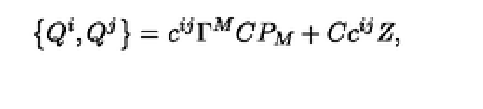

predict LaTeX:

\left\{ Q ^ { i } , Q ^ { j } \right\} = c ^ { i j } \Gamma ^ { M } C P _ { M } + C \epsilon ^ { i j } Z ,


render LaTeX:


<IPython.core.display.Math object>

In [27]:
img_path = "data/images_test/6.png"

import matplotlib.pyplot as plt #plt 用于显示图片
import matplotlib.image as mpimg #mpimg 用于读取图片

print("image path and shape:\n")
lena = mpimg.imread(img_path) #读取目录下的图片，返回 np.array
img = imread(img_path)
img = greyscale(img)
print(img_path, lena.shape)

print("\n\nthe image to predict:")
plt.figure(num=1, figsize=(8,5),)
plt.imshow(lena) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

print("predict LaTeX:\n")
clear_global_attention_slice_stack()
hyps = img2SeqModel.predict(img)
# hyps 是个列表，元素类型是 str, 元素个数等于 beam_search 的 bean_size
# bean_size 在 `./configs/model.json` 里配置，预训练模型里取 2
print(hyps[0])

print("\n\nrender LaTeX:")
displayPreds = lambda LaTeX: display(Math(LaTeX))
displayPreds(hyps[0])

## Show Attention Slices over Image correspond to LaTeX Symbols

In [17]:
LaTeX_symbols_count = len(hyps[0].split(" "))
attention_slices_count = len(model.components.attention_mechanism.ctx_vector)
print("Attention slices：", attention_slices_count)
print("LaTeX symbols：", LaTeX_symbols_count)
print("两者相差 1 ，因为最后一个 attention 预测的字符是尾字符，只起截断作用，不计入 LaTeX")

Attention slices： 51
LaTeX symbols： 48
两者相差 1 ，因为最后一个 attention 预测的字符是尾字符，只起截断作用，不计入 LaTeX


In [14]:
# 模仿卷积层 encoder 缩放
def getWH(img_w, img_h):
    img_w, img_h = np.ceil(img_w / 2), np.ceil(img_h / 2)
    img_w, img_h = np.ceil(img_w / 2), np.ceil(img_h / 2)
    img_w, img_h = np.ceil(img_w / 2), np.ceil(img_h / 2)
    img_w, img_h = np.ceil(img_w - 2), np.ceil(img_h - 2)
    return int(img_w), int(img_h)

def readImageAndShape(img_path):
    lena = mpimg.imread(img_path)  # 读取目录下的图片，返回 np.array
    img = imread(img_path)
    img = greyscale(img)

    img_w, img_h = lena.shape[1], lena.shape[0]

    return img, img_w, img_h

In [6]:
img_w, img_h = lena.shape[1], lena.shape[0]
att_w, att_h = getWH(img_w, img_h)
print(img_w, img_h, att_w, att_h)

240 40 28 3


In [7]:
print("第一个 attention slice 扁平化的长度",
      len(model.components.attention_mechanism.ctx_vector[0][0]))
print("恰好等于 att_w x att_h =", att_w * att_h)

第一个 attention slice 扁平化的长度 84
恰好等于 att_w x att_h = 84


/home/lxy/pyworks/env35/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


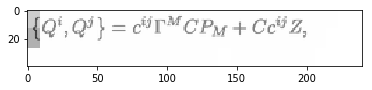

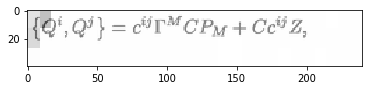

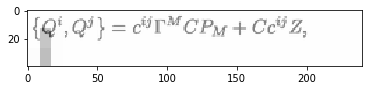

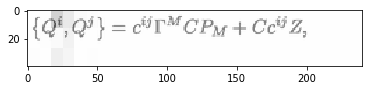

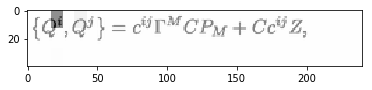

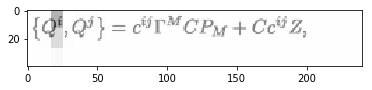

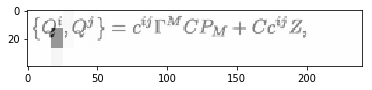

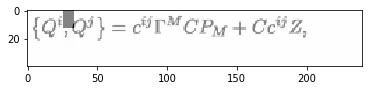

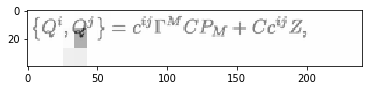

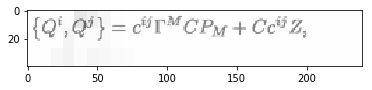

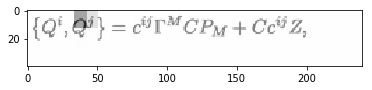

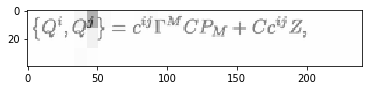

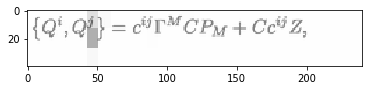

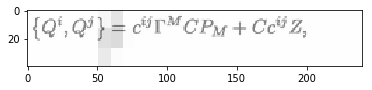

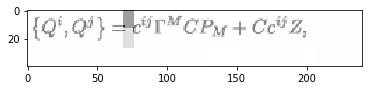

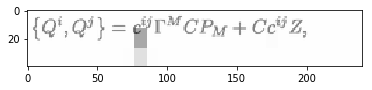

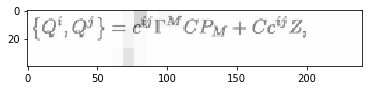

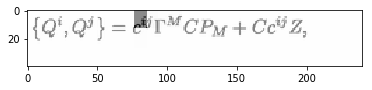

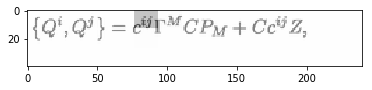

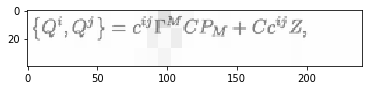

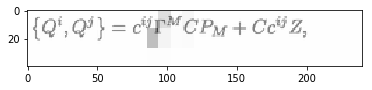

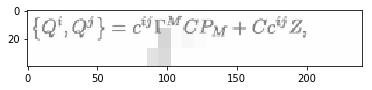

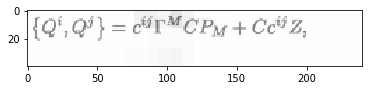

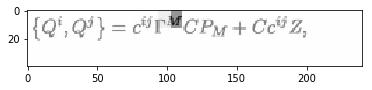

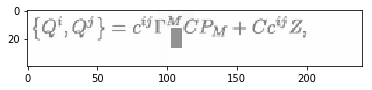

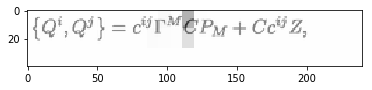

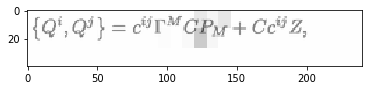

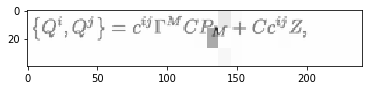

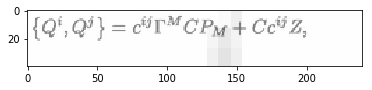

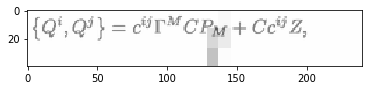

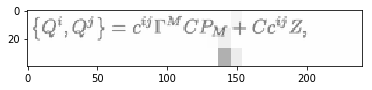

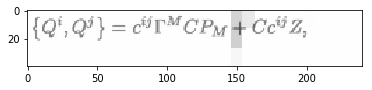

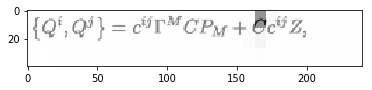

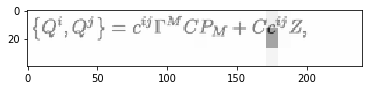

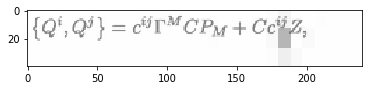

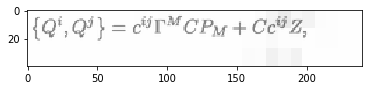

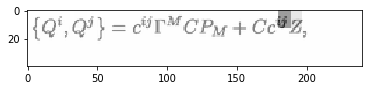

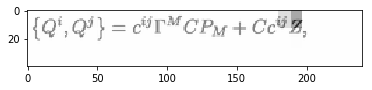

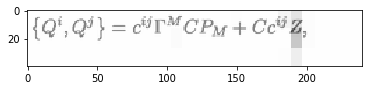

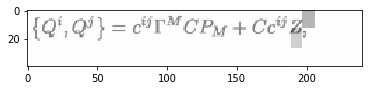

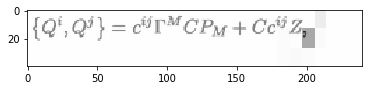

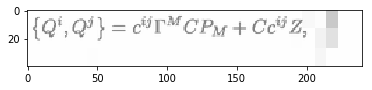

In [8]:
# 可视化所有的 attention slices
for attentionVector in model.components.attention_mechanism.ctx_vector:
    att = sorted(list(enumerate(attentionVector[0].flatten())),
                 key = lambda tup:tup[1],
                 reverse = True) # attention 按权重从大到小递减排序
    idxs,att = zip(*att)

    positions = idxs[:]
    
    # 把扁平化的一维的 attention slice 重整成二维的图片矩阵，像素颜色值范围 [0, 255]
    outarray = np.ones((att_h, att_w)) * 255.
    
    for i in range(len(positions)):
        pos = positions[i]
        loc_x = int(pos / att_w)
        loc_y = int(pos % att_w)
        att_pos = att[i]
        outarray[loc_x, loc_y] = (1 - att_pos) * 255. 
        # (1 - att_pos) * 255. 而不是直接 att_pos * 255
        # 因为颜色值越小越暗，而权重需要越大越暗
    
    out_image = PILImage.fromarray(outarray).resize((img_w, img_h), PILImage.NEAREST)
    inp_image = PILImage.open(img_path)
    
    combine = PILImage.blend(inp_image.convert('RGBA'), out_image.convert('RGBA'),0.5)
    
    plt.figure()
    plt.imshow(np.asarray(combine))

## Save Attention Slices as GIF

it will generate a GIF file look like these.

attention window will slide with the LaTeX symbol predicted one by one. One Attention Slice 
corresponds to one LaTeX Symbol.

![](art/visualization_data.images_test.6.gif)

![](art/visualization_data.images_test.2.gif)

/home/lxy/pyworks/env35/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()


fig size: 72.0 DPI, size in inches [25.  6.]
finish!


/home/lxy/pyworks/env35/lib/python3.5/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


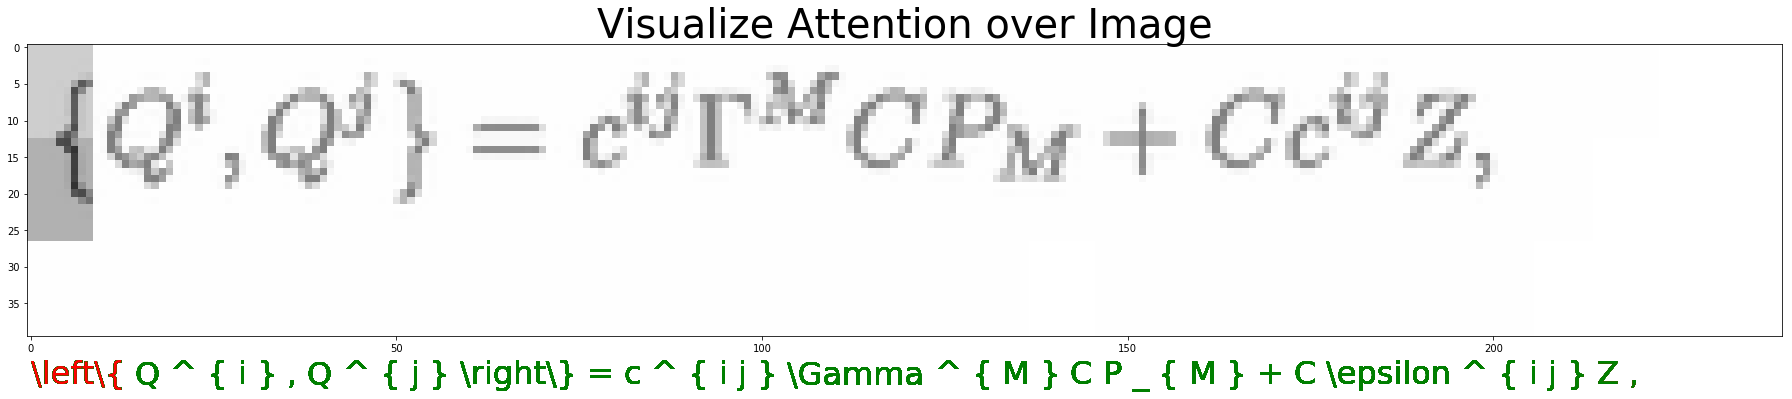

In [28]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import transforms

LaTeX_symbols_count = len(hyps[0].split(" "))
attention_slices_count = len(model.components.attention_mechanism.ctx_vector)
img, img_w, img_h = readImageAndShape(img_path)
att_w, att_h = getWH(img_w, img_h)
    
fig, ax = plt.subplots()
fig.set_tight_layout(True)
fig.set_figwidth(25)
fig.set_figheight(6)

# 询问图形在屏幕上的大小和DPI（每英寸点数）
# 注意当把图形保存为文件时，需要为此单独再提供一个DPI
print('fig size: {0} DPI, size in inches {1}'.format(fig.get_dpi(), fig.get_size_inches()))


def rainbow_text(x, y, strings, colors, ax=None, **kw):
    """
    Take a list of ``strings`` and ``colors`` and place them next to each
    other, with text strings[i] being shown in colors[i].

    This example shows how to do both vertical and horizontal text, and will
    pass all keyword arguments to plt.text, so you can set the font size,
    family, etc.

    The text will get added to the ``ax`` axes, if provided, otherwise the
    currently active axes will be used.
    """
    if ax is None:
        ax = plt.gca()
    t = ax.transData
    canvas = ax.figure.canvas

    # horizontal version
    for s, c in zip(strings, colors):
        text = ax.text(x, y, s + " ", color=c, transform=t, **kw)
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        t = transforms.offset_copy(
            text.get_transform(), x=ex.width, units='dots')

def update(i):
    '''
    在这里绘制动画帧
    args:
       i : (int) range [0, ?)
    return:
       (tuple) 以元组形式返回这一帧需要重新绘制的物体
    '''
    # 1. 更新标题
    LaTeX_symbols = hyps[0].split()
    LaTeX_symbols_count = len(LaTeX_symbols)
    LaTeX_symbols_colors = ['green']*LaTeX_symbols_count
    if i < LaTeX_symbols_count:
        LaTeX_symbols_colors[i] = "red"
#     ax.set_xlabel(label)
    rainbow_text(0, img_h+6 , LaTeX_symbols[:], LaTeX_symbols_colors[:], ax, size=32)
    
    # 2. 更新图片
    attentionVector = model.components.attention_mechanism.ctx_vector[i][0]
    att = sorted(list(enumerate(attentionVector.flatten())),
                 key = lambda tup:tup[1],
                 reverse = True) # attention 按权重从大到小递减排序
    idxs,att = zip(*att)
#     j=1
#     while sum(att[:j])<0.9:
#         # 取 90% 的 attention
#         j+=1
    positions = idxs[:]
    
    # 把扁平化的一维的 attention slice 重整成二维的图片矩阵，像素颜色值范围 [0, 255]
    outarray = np.ones((att_h, att_w)) * 255.
    
    for i in range(len(positions)):
        pos = positions[i]
        loc_x = int(pos / att_w)
        loc_y = int(pos % att_w)
        att_pos = att[i]
        outarray[loc_x, loc_y] = (1 - att_pos) * 255. 
        # (1 - att_pos) * 255. 而不是直接 att_pos * 255
        # 因为颜色值越小越暗，而权重需要越大越暗
    
    out_image = PILImage.fromarray(outarray).resize((img_w, img_h), PILImage.NEAREST)
    inp_image = PILImage.open(img_path)
    
    combine = PILImage.blend(inp_image.convert('RGBA'), out_image.convert('RGBA'),0.5)
    
    ax.imshow(np.asarray(combine))
    
    # 3. 以元组形式返回这一帧需要重新绘制的物体
    return ax

# 会为每一帧调用Update函数
# 这里FunAnimation设置一个10帧动画，每帧间隔200ms
plt.title("Visualize Attention over Image", fontsize=40)
anim = FuncAnimation(fig, update, frames=np.arange(0, LaTeX_symbols_count), interval=200)
anim.save('visualization1.gif', dpi=80, writer='imagemagick')
print("finish!")